In [125]:
import warnings

import geopandas
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')
geopandas.options.io_engine = "pyogrio"
%matplotlib inline
%load_ext autoreload
%autoreload 2

from sqlalchemy import create_engine
from config import PostgresReadOnlyConfig

conn_str = PostgresReadOnlyConfig().__str__()
engine = create_engine(conn_str)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
def discharge_interval_query(parameters: list[str], locations: list[str], site_number: str):
    parameters_csv = ','.join(f"'{p}'" for p in parameters)
    locations_csv = ','.join(f"'{l}'" for l in locations)

    query_template = f"""
    with
    sample_date as (
     select wq.sample_date_time::date as sample_date from public.water_quality wq 
     where parameter IN ({parameters_csv})
        and wq.sample_location in ({locations_csv})
    ),
    intervals as (
    select 
            (select min(s.sample_date) from sample_date s) + ( n    || ' day')::interval start_date,
            (select min(s.sample_date) from sample_date s) + ((n+120) || ' day')::interval end_date
          from generate_series(
          0, 
          ((select max(s.sample_date)::date from sample_date s) - (select min(s.sample_date)::date from sample_date s)),
          120) n
      )
    select  
    'USGS-' || max(d.site_number) as site_number,
    max(d.geometry) as geometry,
    max(d."parameter") as "parameter",
    avg(d.avg_value) as avg_value,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY d.avg_value) as median_value,
    max(d.avg_value) as max_value,
    min(d.avg_value) as min_value,
    max(d.unit) as unit,
    i.start_date, 
    i.end_date
    from intervals i
       right join public.discharge_daily d on d.date_time::date >= i.start_date and d.date_time::date < i.end_date
        and "parameter" = 'Discharge' and d.site_number = '{site_number}'
        group by i.start_date, i.end_date
        order by i.start_date desc;
    """    
    df = geopandas.read_postgis(
    sql=query_template,
    con=engine, geom_col='geometry', crs="EPSG:26914")
    return df
    

In [127]:
def water_quality_interval_query(parameters: list[str], locations: list[str], parameter: str, unit: str):
    parameters_csv = ','.join(f"'{p}'" for p in parameters)
    locations_csv = ','.join(f"'{l}'" for l in locations)

    query_template = f"""
        with 
        sample_date as (
             select wq.sample_date_time::date as sample_date from public.water_quality wq 
             where parameter IN ({parameters_csv})
                and wq.sample_location in ({locations_csv})
        ),
        intervals as (
            select 
                (select min(s.sample_date) from sample_date s) + ( n    || ' day')::interval start_date,
                (select min(s.sample_date) from sample_date s) + ((n+120) || ' day')::interval end_date
              from generate_series(
              0, 
              ((select max(s.sample_date)::date from sample_date s) - (select min(s.sample_date)::date from sample_date s)),
              120) n
          )
          SELECT 
            max(sample_location) as sample_location,
            max(wq.geometry) as geometry,
            max("parameter") as "parameter",
            avg(wq.value) as avg_value,
            PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY wq.value) as median_value,
            max(wq.value) as max_value,
            min(wq.value) as min_value,
            max(wq.unit) as unit,
           i.start_date, 
           i.end_date
           FROM intervals i
           left outer join public.water_quality wq on wq.sample_date_time::date >= i.start_date and wq.sample_date_time::date < i.end_date  
               and parameter IN ({parameters_csv})
                and wq.sample_location in ({locations_csv})
            group by i.start_date, i.end_date
            order by i.start_date desc;
    """

    df = geopandas.read_postgis(
        sql=query_template,
        con=engine, geom_col='geometry', crs="EPSG:26914")
    df["unit"] = unit
    df["parameter"] = parameter
    return df


In [128]:
import pandas

locations_24th = ["Shoal Creek @ 24th Street"]
locations_12th = ["USGS-08156800"]
locations_1st_upstream = ["Shoal Creek Upstream of 1st St"]

coa_parameters = {
    "tss": ["TOTAL SUSPENDED SOLIDS"],
    # "tds": ["TOTAL DISSOLVED SOLIDS"],
    "ph": ["PH"],
    "temperature": ["WATER TEMPERATURE"],
    "conductivity": ["CONDUCTIVITY"],
    "turbidity": ["TURBIDITY"], 
    "n0": ["NITRATE AS N"],
    "p04": ["PHOSPHORUS AS P", "ORTHOPHOSPHORUS AS P"]
}
usgs_parameters = {
    "n0": ["Inorganic nitrogen (nitrate and nitrite)", "Kjeldahl nitrogen", "Organic Nitrogen", "Nitrite", "Nitrate", "Nitrogen, mixed forms (NH3), (NH4), organic, (NO2) and (NO3)"],
    "p04": ["Phosphorus", "Orthophosphate"],
    "ph": ["pH"],
    # "tds": ["Total dissolved solids"],
    "turbidity": ["Turbidity"],
    "conductivity": ["Specific conductance"],
    "tss": ["Total suspended solids"],
    "temperature": ["Temperature, water"]
}

units = {
    "n0": "mg/l",
    "p04": "mg/l",
    "ph": "std units",
    # "tds": "ppm",
    "turbidity": "NTU",
    "conductivity": "uS/cm",
    "tss": "mg/L",
    "temperature": "deg C"
}

wq_24th_intervals = geopandas.GeoDataFrame()
for parameter in usgs_parameters:
    df = water_quality_interval_query(parameters=coa_parameters[parameter], locations=locations_12th, unit=units[parameter], parameter=parameter)
    wq_24th_intervals = pandas.concat([wq_24th_intervals, df])

wq_12th_intervals = geopandas.GeoDataFrame()
discharge_12th_intervals = geopandas.GeoDataFrame()
for parameter in usgs_parameters:
    wq_df = water_quality_interval_query(parameters=usgs_parameters[parameter], locations=locations_12th, unit=units[parameter], parameter=parameter)
    wq_12th_intervals = pandas.concat([wq_12th_intervals, wq_df])

    discharge_df = discharge_interval_query(parameters=usgs_parameters[parameter], locations=locations_12th, site_number="08156800")
    discharge_12th_intervals = pandas.concat([discharge_12th_intervals, discharge_df])


wq_1st_upstream_intervals = geopandas.GeoDataFrame()
for parameter in usgs_parameters:
    df =  water_quality_interval_query(parameters=coa_parameters[parameter], locations=locations_12th, unit=units[parameter], parameter=parameter)
    wq_1st_upstream_intervals = pandas.concat([wq_1st_upstream_intervals, df])


In [129]:
wq_12th_intervals.head()

,sample_location,geometry,parameter,avg_value,median_value,max_value,min_value,unit,start_date,end_date
0,USGS-08156800,POINT (-97.750 30.277),n0,1.647333,0.420,4.3,0.013,mg/l,2018-02-05,2018-06-05
1,USGS-08156800,POINT (-97.750 30.277),n0,0.917500,0.635,2.1,0.009,mg/l,2017-10-08,2018-02-05
2,USGS-08156800,POINT (-97.750 30.277),n0,0.988375,0.578,2.3,0.009,mg/l,2017-06-10,2017-10-08
3,None,None,n0,NaN,NaN,NaN,NaN,mg/l,2017-02-10,2017-06-10
4,None,None,n0,NaN,NaN,NaN,NaN,mg/l,2016-10-13,2017-02-10


In [130]:
discharge_12th_intervals.head()

,site_number,geometry,parameter,avg_value,median_value,max_value,min_value,unit,start_date,end_date
0,USGS-08156800,POINT (-97.750 30.277),Discharge,4.289461,0.07,435.0,0.0,cfs,NaT,NaT
1,USGS-08156800,POINT (-97.750 30.277),Discharge,6.632000,0.14,314.0,0.0,cfs,2018-02-05,2018-06-05
2,USGS-08156800,POINT (-97.750 30.277),Discharge,1.871917,0.08,116.0,0.0,cfs,2017-10-08,2018-02-05
3,USGS-08156800,POINT (-97.750 30.277),Discharge,8.736167,0.00,338.0,0.0,cfs,2017-06-10,2017-10-08
4,USGS-08156800,POINT (-97.750 30.277),Discharge,3.491250,0.66,61.0,0.0,cfs,2017-02-10,2017-06-10


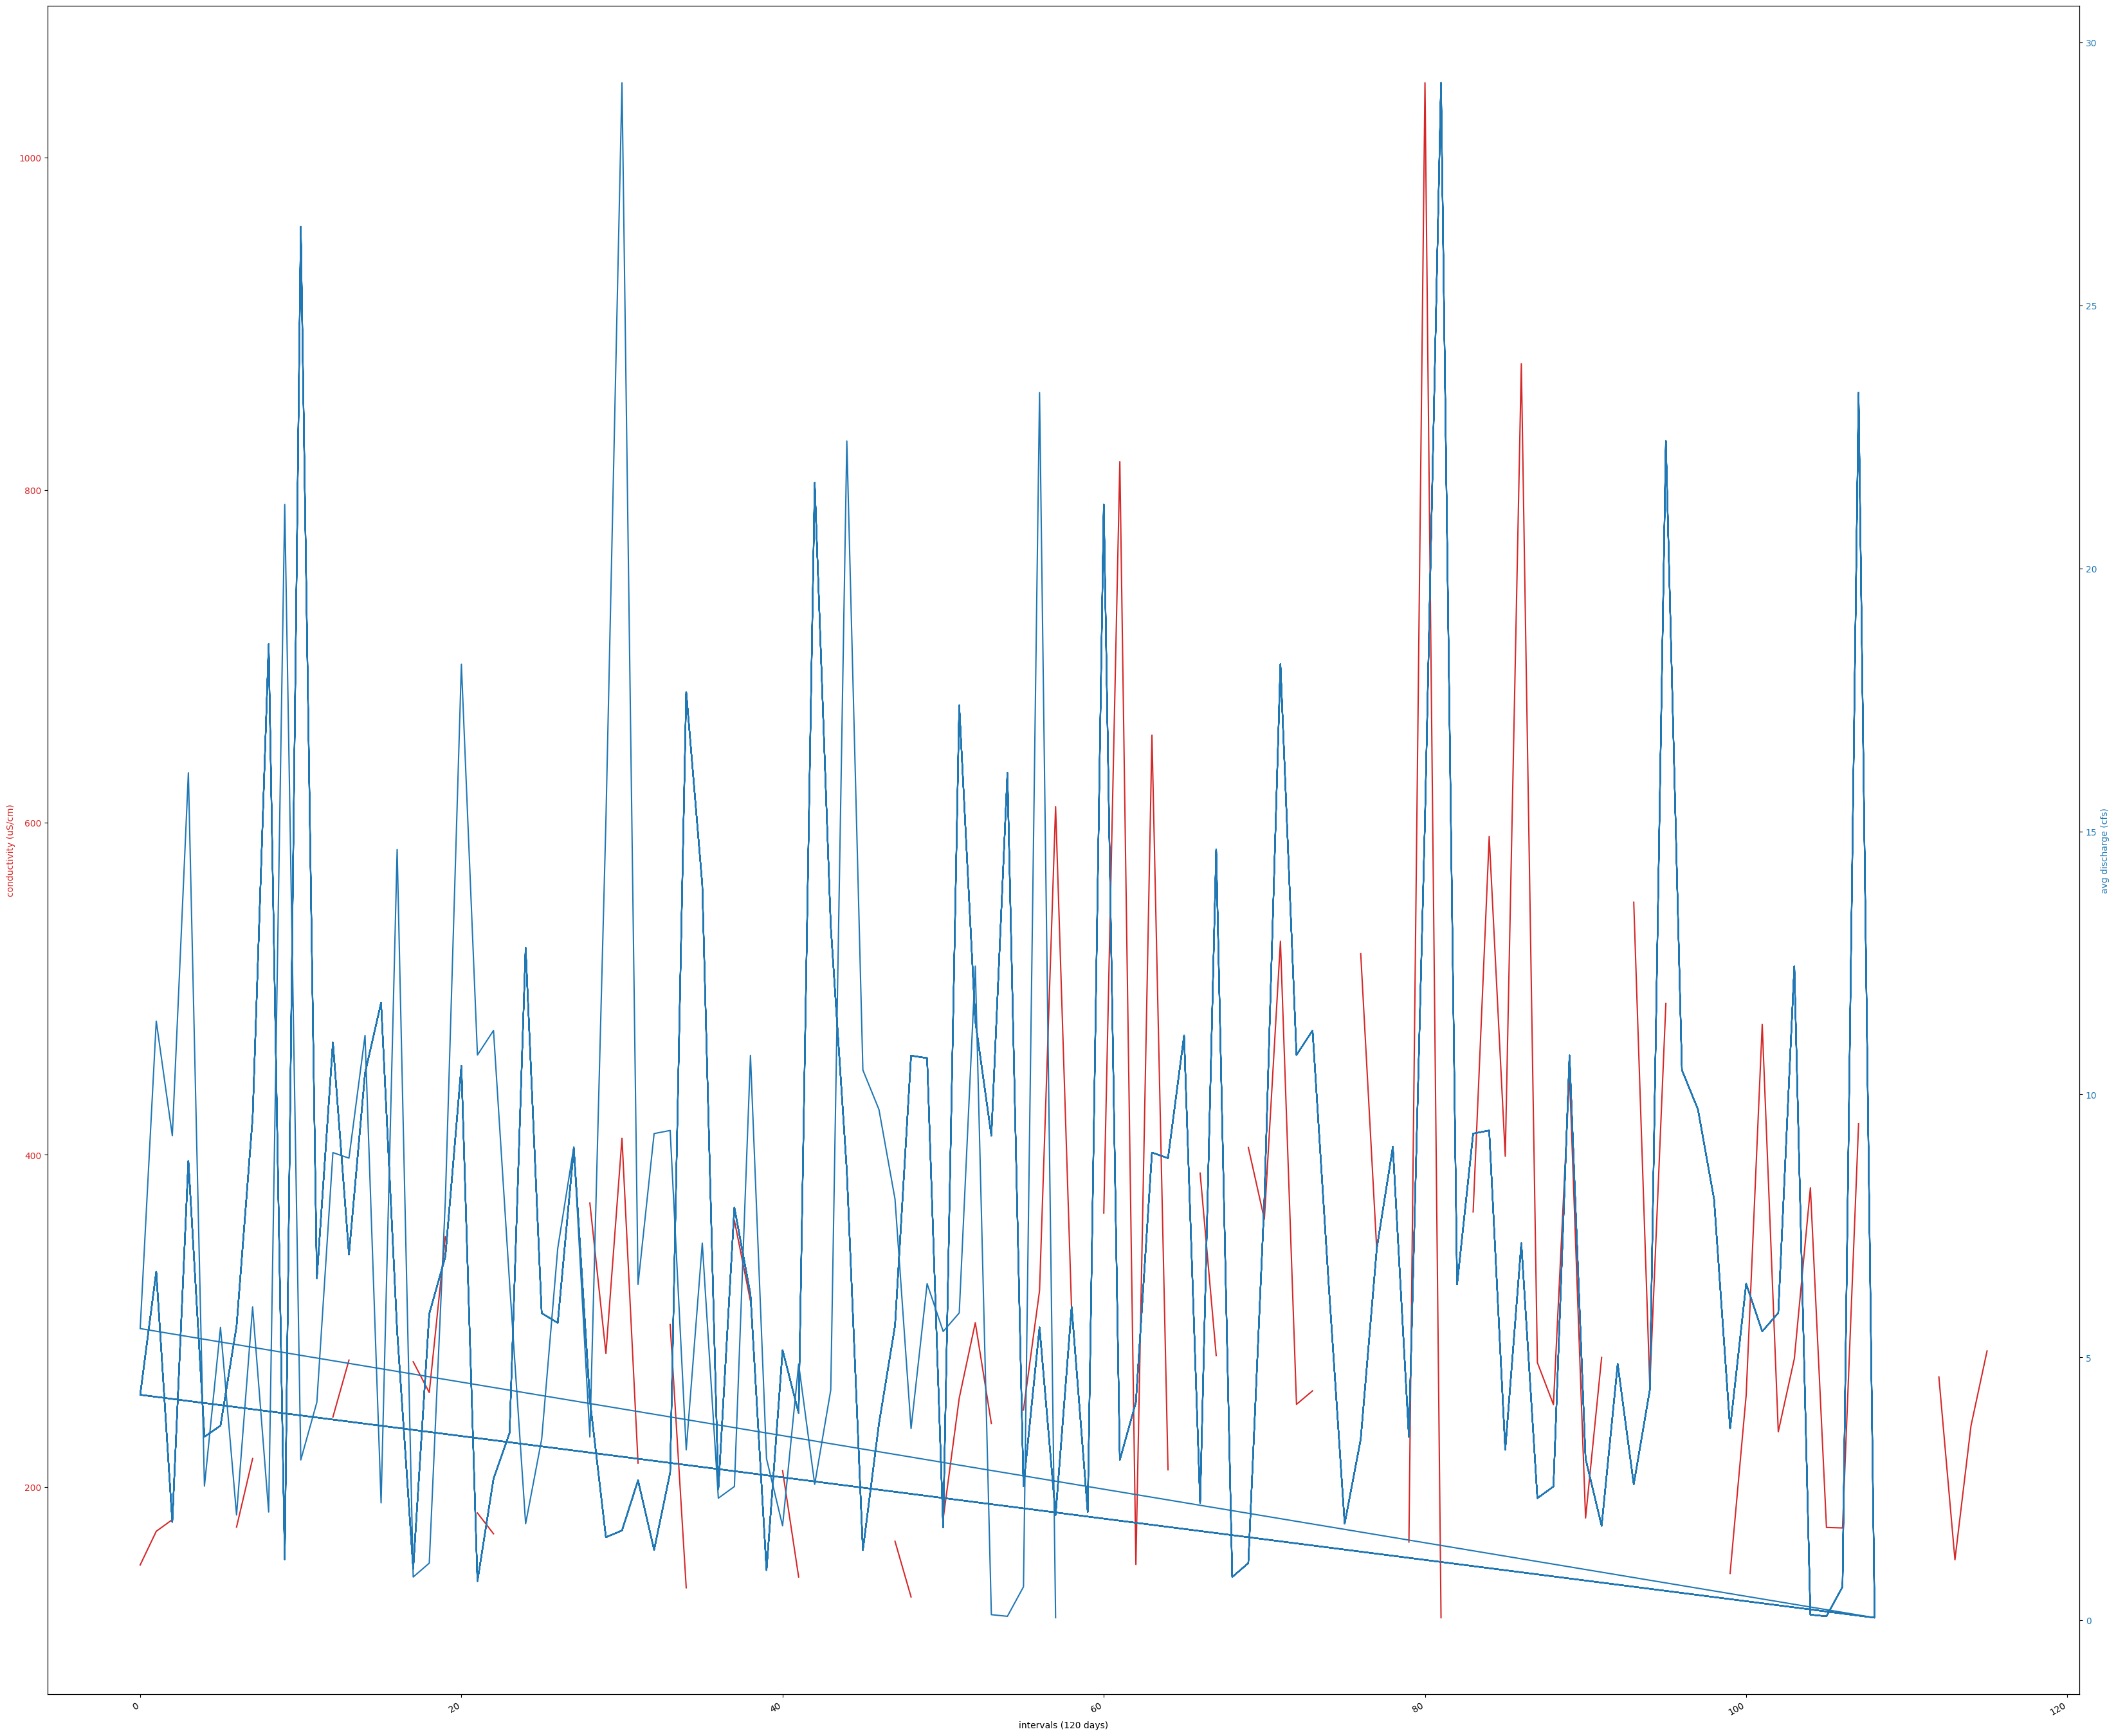

In [133]:
fig, ax1 = plt.subplots(figsize=(33,33))

color = 'tab:red'
ax1.set_xlabel('intervals (120 days)')
ax1.set_ylabel('conductivity (uS/cm)', color=color)
ax1.plot(wq_12th_intervals[wq_12th_intervals["parameter"] == 'conductivity']['avg_value'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('avg discharge (cfs)', color=color)
ax2.plot(discharge_12th_intervals['avg_value'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.autofmt_xdate()
plt.show()